In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
%pylab inline
import readgadget
from tqdm import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk

In [4]:
mesh_shape= [128, 128, 128]
box_size  = [200.,200.,200.]

In [5]:
from jax.experimental.ode import odeint

from jaxpm.utils import power_spectrum
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel

In [6]:
snapshots = jnp.array([
 0.14285714254594556,
 0.16666666542893738,
 0.1999999986832461,
 0.22222222150378537,
 0.24999999806336917,
 0.2622410627683301,
 0.27508150213837845,
 0.2885506615021642,
 0.3026793308840415,
 0.3174997972262324,
 0.3330459395932943,
 0.3493532841474449,
 0.36645910890451366,
 0.38440250769880274,
 0.4032244880783829,
 0.42296807642809625,
 0.4436783909454936,
 0.46540277468080926,
 0.4881908767722827,
 0.5120947767731064,
 0.5371691181575536,
 0.5634712010003641,
 0.5910611509374005,
 0.6200020223344457,
 0.6503599561823248,
 0.682204349649582,
 0.7156079737852235,
 0.7506471880986196,
 0.7874020715837913,
 0.8259566232460903,
 0.8663989774339641,
 0.9088215533213413,
 0.9533213274239392,
 0.9999999999999998])

In [7]:
# Create a small function to generate the matter power spectrum
k = jnp.logspace(-4, 2, 256)
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)
pk = jc.power.linear_matter_power(cosmo, k)
pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

# Create initial conditions
initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))

# Create particles
particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)
# Initial displacement
dx, p, f = lpt(cosmo, initial_conditions, particles,snapshots[0])

/local/home/dl264294/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4457: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


In [8]:
# Evolve the simulation forward
resi = odeint(make_ode_fn(mesh_shape), [particles+dx, p], snapshots[::2], cosmo, rtol=1e-5, atol=1e-5)

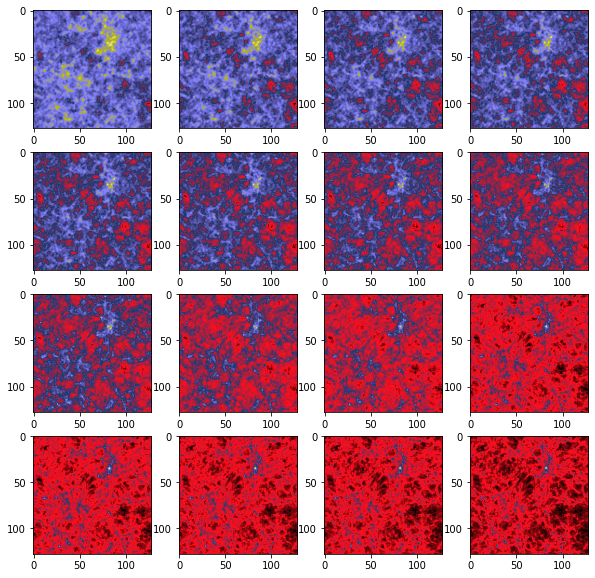

In [9]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][i]).sum(axis=0), cmap='gist_stern')

In [10]:
k, pk_i = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array(box_size),
      kmin=np.pi / box_size[0],
      dk=2 * np.pi / box_size[0])

/local/home/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


In [11]:
from jaxpm.nn import NeuralSplineFourierFilter

In [12]:
model = hk.without_apply_rng(hk.transform(lambda x,a : NeuralSplineFourierFilter(n_knots=16, latent_size=32)(x,a)))
import pickle
params = pickle.load( open( "camels_25_64_CV_0.params", "rb" ) )

In [13]:
def neural_nbody_ode(state, a, cosmo, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    
    delta_k = jnp.fft.rfftn(delta)
    
    # Computes gravitational potential
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
    
    # Apply a correction filter
    kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
    pot_k = pot_k *(1. + model.apply(params, kk, jnp.atleast_1d(a)))
    
    # Computes gravitational forces
    forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                      for i in range(3)],axis=-1)
    
    forces = forces * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [14]:
res = odeint(neural_nbody_ode, [particles+dx, p], snapshots[::2], cosmo, params, rtol=1e-5, atol=1e-5)

/tmp/ipykernel_829522/1752112647.py:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))


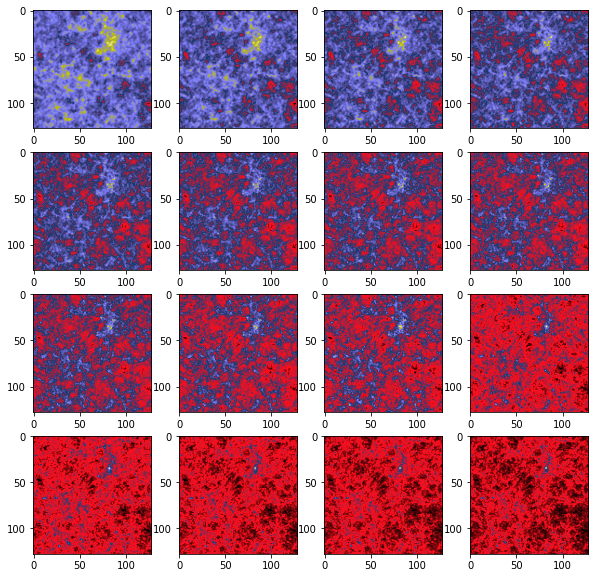

In [15]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), res[0][i]).sum(axis=0), cmap='gist_stern')

In [16]:
inds = -1
print('z', 1./snapshots[::2][inds] -1)
pk_ref = jc.power.nonlinear_matter_power(cosmo, k, snapshots[::2][inds])

k, pk_i = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi[0][inds])),
      boxsize=np.array(box_size),
      kmin=np.pi / box_size[0],
      dk=2 * np.pi / box_size[0])

k, pk = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), res[0][inds])),
      boxsize=np.array(box_size),
      kmin=np.pi / box_size[0],
      dk=2 * np.pi / box_size[0])

pk_ref = jc.power.nonlinear_matter_power(cosmo, k, snapshots[::2][inds])


z 0.048964262


In [17]:
params_pgd = pickle.load( open( "camels_25_64_pkloss_PGD_CV_0.params", "rb" ) )
params_pgd=[params_pgd[0],params_pgd[1]*mesh_shape[0]//box_size[0],params_pgd[2]*mesh_shape[0]//box_size[0]]

In [18]:
def PGD_kernel(kvec, kl, ks):

  kk = sum(ki**2 for ki in kvec)
  kl2 = kl**2
  ks4 = ks**4
  mask = (kk == 0).nonzero()
  kk[mask] = 1
  v = jnp.exp(-kl2 / kk) * jnp.exp(-kk**2 / ks4)
  imask = (~(kk == 0)).astype(int)
  v *= imask
  return v

def pgd_correction(pos, cosmo, params):
    """
    state is a tuple (position, velocities)
    """

    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    alpha, kl, ks = params
    delta_k = jnp.fft.rfftn(delta)
    PGD_range=PGD_kernel(kvec, kl, ks)
    
    pot_k_pgd=(delta_k * laplace_kernel(kvec))*PGD_range

    forces_pgd= jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k_pgd), pos) 
                      for i in range(3)],axis=-1)
    
    dpos_pgd = forces_pgd*alpha
   
    return dpos_pgd

In [19]:
k, pk_pgd = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi[0][-1]+pgd_correction(resi[0][-1], cosmo,params_pgd))),
      boxsize=np.array(box_size),
      kmin=np.pi / box_size[0],
      dk=2 * np.pi / box_size[0])



/tmp/ipykernel_829522/1135245045.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = sum(ki**2 for ki in kvec)


In [20]:
import cmasher as cmr
import matplotlib.colors as colors

cmap = cmr.eclipse  
col = cmr.eclipse([0.,0,0.55,0.85]) 

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0., vmax=1))

Text(0, 0.5, '$P(k)$')

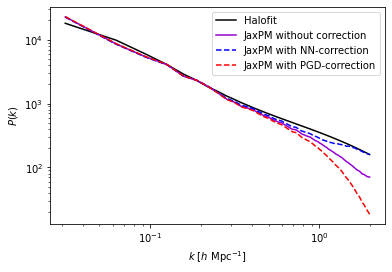

In [21]:

loglog(k, pk_ref,label='Halofit',color='black')
loglog(k, pk_i, label='JaxPM without correction',color='darkviolet')
loglog(k, pk, '--', label='JaxPM with NN-correction',color='blue')
loglog(k, pk_pgd, '--', label='JaxPM with PGD-correction',color='red')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
#plt.savefig('../figures/halofit_comparison_wrong_boxsize_res.pdf')

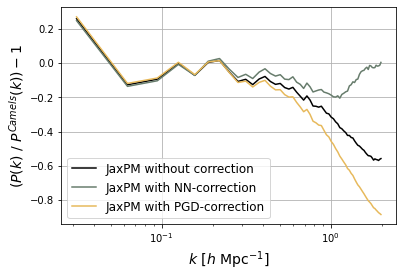

In [22]:
semilogx(k, (pk_i/pk_ref)-1,label='JaxPM without correction',color=col[1])
semilogx(k, (pk/pk_ref)-1,label='JaxPM with NN-correction',color=col[2])    
semilogx(k, (pk_pgd/pk_ref)-1,label='JaxPM with PGD-correction',color=col[3]) 
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",fontsize=14)
plt.ylabel(r"$ (P(k) \ / \ P^{Camels}(k))-1$",fontsize=14)
plt.grid(True)
legend(fontsize='large')
#plt.savefig('../figures/halofit_residuals_wrong_boxsize_res_nottile.pdf')